# DNN: analysis with Keras of 2D data

In [1]:
try:
    import cayde_env # importing a custom environment for my server
    cayde_env.tensorflow('CPU')
except: print('no need of custom environment')

 [ CAYDE computing env ]
[tf] CPU set

In [2]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

%run nonlinear_function.py

# training data
perc_train = 0.8

2
[-31.60811883 -29.54397214] 1.0
[6.77250291 9.5544703 ] 0.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 0.0
data: 20000
train: 16000


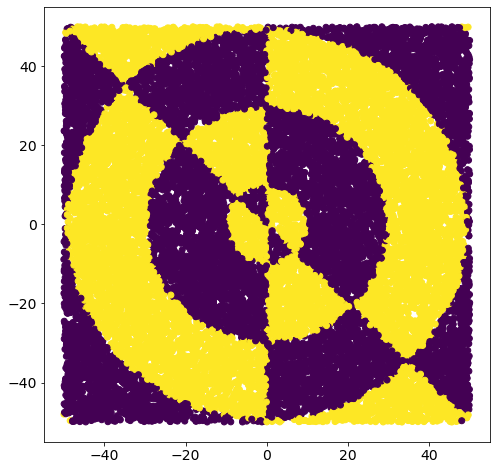

In [3]:
# Keras works with numpy arrays: just use them from the start
TYPE = 1
x = np.loadtxt('DATA/data-for-DNN-2type-2n-dim.dat', delimiter=' ')
y = np.loadtxt('DATA/labels-for-DNN-2type-2n-dim.dat', delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(L)

for i in range(10):
    print(x[i], y[i])

N_train = int(perc_train*N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize=(8,8))
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

# Split training and test data

In [4]:
x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]
print("Train:", len(x_train), "\t Validation:", len(x_valid))

Train: 16000 	 Validation: 4000


# Rescale input data

In [5]:
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

# Define the model with Keras

In [6]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import keras,sklearn
from tensorflow.keras import layers

In [7]:
def create_DNN_GridSearch(activation, dropout_rate, layers):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation = activation))
    for i in range(len(layers)):
        model.add(Dense(layers[i],activation = activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid"))
    return model
    
def compile_model(optimizer="Adam", activation = "relu", dropout_rate = 0.1, layers = (20, 20, 20, 20, 20,)):
    # create the mode
    model=create_DNN_GridSearch(activation, dropout_rate, layers)
    # compile the model
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model


In [8]:
# # call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# # list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# define parameter dictionary
param_grid = dict(optimizer=optimizer, activation = activation, dropout_rate=dropout_rate)
# # call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=200, batch_size = 10, shuffle = True,verbose=False)# epochs and batch sizes have to be increased, but we need a powerful computer

/tmp/ipykernel_211636/2378154642.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_gridsearch = KerasClassifier(build_fn = compile_model)
2022-03-16 19:23:24.065464: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-03-16 19:23:24.066234: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-03-16 19:23:24.252374: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-03-16 19:23:24.253638: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-03-16 19:23:24.358567: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-03-16 19:23:24.359913: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could no

KeyboardInterrupt: 

In [ ]:
# summarize results
print("best %f%% using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
grid_results_sorted = sorted(zip(means, stds, params), key=lambda x: x[0], reverse=True)

print('\n======= all results ======')
for mean, stdev, param in grid_results_sorted: #sorted( grid_results_sorted , key=lambda x: x[2]['optimizer'], reverse=True):
    print("%f (+-%f) with: %r" % (mean, stdev, param))

# Training on most accurate model

In [9]:
chosen_params = {'activation': 'softplus', 'dropout_rate': 0.0, 'optimizer': 'Nadam'} # paste here the model to use

model = compile_model(**chosen_params, layers = (20, 20))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
fit = model.fit(x_train, y_train,
                epochs = 2000, batch_size = 50,
                validation_data = (x_valid, y_valid),
                verbose = 2)

2022-03-16 19:23:32.841747: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-03-16 19:23:32.842642: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice


Epoch 1/2000
320/320 - 1s - loss: 0.7019 - accuracy: 0.5019 - val_loss: 0.6948 - val_accuracy: 0.4938 - 616ms/epoch - 2ms/step
Epoch 2/2000
320/320 - 0s - loss: 0.6940 - accuracy: 0.5003 - val_loss: 0.6949 - val_accuracy: 0.4938 - 184ms/epoch - 574us/step
Epoch 3/2000
320/320 - 0s - loss: 0.6940 - accuracy: 0.5036 - val_loss: 0.6962 - val_accuracy: 0.4938 - 184ms/epoch - 576us/step
Epoch 4/2000
320/320 - 0s - loss: 0.6936 - accuracy: 0.5027 - val_loss: 0.6943 - val_accuracy: 0.4938 - 188ms/epoch - 588us/step
Epoch 5/2000
320/320 - 0s - loss: 0.6937 - accuracy: 0.5099 - val_loss: 0.6936 - val_accuracy: 0.5063 - 191ms/epoch - 597us/step
Epoch 6/2000
320/320 - 0s - loss: 0.6938 - accuracy: 0.5027 - val_loss: 0.6972 - val_accuracy: 0.4938 - 176ms/epoch - 550us/step
Epoch 7/2000
320/320 - 0s - loss: 0.6938 - accuracy: 0.5046 - val_loss: 0.6935 - val_accuracy: 0.5063 - 173ms/epoch - 540us/step
Epoch 8/2000
320/320 - 0s - loss: 0.6935 - accuracy: 0.5029 - val_loss: 0.6943 - val_accuracy: 0.49

KeyboardInterrupt: 

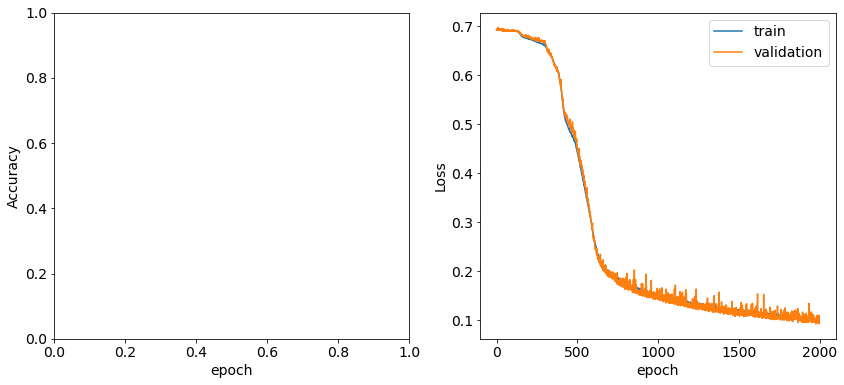

In [10]:
fig, AX = plt.subplots(1, 2, figsize=(14,6.))
ax = AX[0]
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax = AX[1]
ax.plot(fit.history['loss'], label="train")
ax.plot(fit.history['val_loss'], label="validation")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [11]:
dX = 2
X1 = np.arange(-50, 50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:] = (X1[j], X1[i])
        k = k+1
print(len(X1), len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model.predict(grid_r)

51 2601
[50. 50.]


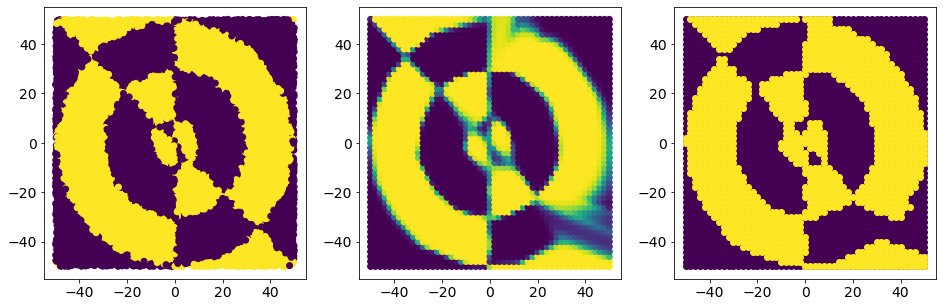

In [12]:
def boundaries():    
    ax.plot((-20,-20), (-40,50), c="w")
    ax.plot((-20,50), (-40,-40), c="w")
    ax.plot((-10,50), (50,-10), c="w")
fig, AX = plt.subplots(1, 3, figsize=(16,5.))
ax = AX[0]
ax.scatter(x[:,0], x[:,1], c=y)
#boundaries()
ax = AX[1]
ax.scatter(grid[:,0], grid[:,1], c=pred)
#boundaries()
ax = AX[2]
W1 = np.where(pred > 0.5)[0] 
ax.scatter(grid[:,0], grid[:,1], c="#440154")
ax.scatter(grid[W1,0], grid[W1,1], c="#fde725")
#boundaries()
plt.show()

End of file